Bayesian GPLVM with full rank covariance
--
This notebook shows the difference between a full rank and a diagonal variational distribution over the latent values.

In [1]:
import GPflow
from GPflow import ekernels
from GPflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
%matplotlib inline
import pods
pods.datasets.overide_manual_authorize = True  # dont ask to authorize
np.random.seed(42)
GPflow.settings.numerics.quadrature = 'error'  # throw error if quadrature is used for kernel expectations

### Data
Install the oil dataset.

In [2]:
data = pods.datasets.oil_100()
Y = data['X']
print('Number of points X Number of dimensions', Y.shape)
data['citation']

Number of points X Number of dimensions (100, 12)


'Bishop, C. M. and G. D. James (1993). Analysis of multiphase flows using dual-energy gamma densitometry and neural networks. Nuclear Instruments and Methods in Physics Research A327, 580-593'

### Model construction
Create Bayesian GPLVM model using additive kernel.

In [3]:
Q = 5
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = GPflow.gplvm.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]
kerngen = lambda: ekernels.RBF(Q, ARD=True)

In [4]:
mdiag = GPflow.gplvm.BayesianGPLVM(X_mean=X_mean.copy(), X_std=0.1**0.5*np.ones((N, Q)), Y=Y,
                                kern=kerngen(), M=M, Z=Z.copy())
mdiag.likelihood.variance = 0.01
mdiag.optimize(disp=True, max_iters=100)

/Users/markvdw/Documents/projects/gpflow/GPflow/model.py:282: VisibleDeprecationWarning: Use `maxiter` instead of deprecated `max_iters`.
  warnings.warn("Use `maxiter` instead of deprecated `max_iters`.", np.VisibleDeprecationWarning)


      fun: array([-55.76014601])
 hess_inv: <1107x1107 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.78151677e-01,   4.35708900e-01,   6.95508368e-04, ...,
         4.32734021e-01,  -2.69053623e-01,   1.15131604e-01])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 109
      nit: 101
   status: 1
  success: False
        x: array([ 2.26896799,  8.07097457,  2.81557485, ...,  0.76222254,
        1.06002485,  0.16109891])

In [6]:
X_std_full = np.array([0.1**0.5*np.eye(Q) for _ in range(N)])
mfull = GPflow.gplvm.BayesianGPLVM(X_mean=X_mean.copy(), X_std=X_std_full, Y=Y,
                                kern=kerngen(), M=M, Z=Z.copy())
mfull.likelihood.variance = 0.01
mfull.optimize(disp=True, max_iters=100)

/Users/markvdw/Documents/projects/gpflow/GPflow/model.py:282: VisibleDeprecationWarning: Use `maxiter` instead of deprecated `max_iters`.
  warnings.warn("Use `maxiter` instead of deprecated `max_iters`.", np.VisibleDeprecationWarning)


      fun: array([-313.8978956])
 hess_inv: <3107x3107 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.10379347,  0.59952768, -0.63828397, ..., -0.6009192 ,
        0.09215712, -0.46737469])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 104
      nit: 101
   status: 1
  success: False
        x: array([ 9.29645017,  3.2733933 ,  9.21135779, ..., -0.04729628,
       -0.37093613,  0.07516274])

In [7]:
print(mdiag.kern)

kern.variance transform:+ve prior:None
[ 2.3673824]
kern.lengthscales transform:+ve prior:None
[  8.071288     2.87372239  10.78976216   8.30331504  20.76789867]


In [8]:
print(mfull.kern)

kern.lengthscales transform:+ve prior:None
[  9.29654292   3.31057224   9.21145869  12.21376071  13.5914863 ]
kern.variance transform:+ve prior:None
[ 4.58718212]


### Compute and sensitivity to input
Sensitivity is a measure of the importance of each latent dimension. 

[ 0.19063005  0.5354136   0.14260092  0.1853031   0.07408694]
[ 0.23038357  0.64694882  0.23251158  0.17535719  0.15758179]


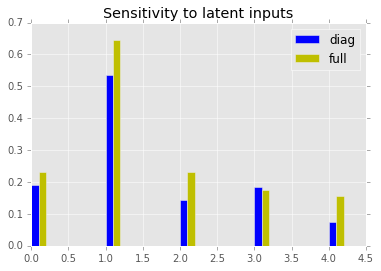

In [30]:
colours = ['b', 'y']
labels = ['diag', 'full']
for i, m in enumerate([mdiag, mfull]):
    kern = m.kern
    sens = np.sqrt(kern.variance.value)/kern.lengthscales.value
    print(sens)
    #fig, ax = plt.subplots()
    plt.bar(np.arange(len(kern.lengthscales.value)) + 0.1 * i , sens, 0.1, color=colours[i], label=labels[i])
    plt.legend()
    plt.title('Sensitivity to latent inputs')

### Plotting vs PCA
We see that using the 2 more relevant dimensions, the Bayesian GPLVM is able to seperate the
three classes while PCA cannot.

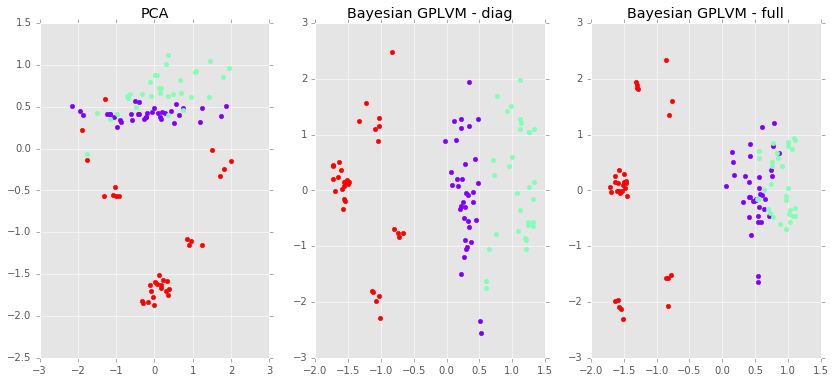

In [10]:
XPCAplot = GPflow.gplvm.PCA_reduce(data['X'], 2)
f, ax = plt.subplots(1,3, figsize=(14,6))
labels=data['Y'].argmax(axis=1)
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[labels==i,0], XPCAplot[labels==i,1], color=c, label=i)
    ax[0].set_title('PCA')
    ax[1].scatter(mdiag.X_mean.value[labels==i,1], mdiag.X_mean.value[labels==i,2], color=c, label=i)
    ax[1].set_title('Bayesian GPLVM - diag')
    ax[2].scatter(mfull.X_mean.value[labels==i,1], mfull.X_mean.value[labels==i,2], color=c, label=i)
    ax[2].set_title('Bayesian GPLVM - full')